In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
qml.drawer.use_style(style='sketch')

In [3]:
from pennylane.operation import Operation

class Oracle(Operation):
    num_params = 2
    num_wires = qml.operation.AnyWires

    @staticmethod
    def compute_decomposition(N, seed, wires):
        # Set seed for np.random
        np.random.seed(seed)
        gates = []
        
        # Choose N qubits to apply X gate
        N_X = np.random.randint(1, N)
        target_qubits = np.random.choice(N, size=N_X, replace=False)
        for i in range(N_X):
            gates.append(qml.PauliX(wires=wires[target_qubits[i] + N]))

        p_scenario = np.random.randint(2)
        # CNOT(N - 1 -> N - 1)
        if p_scenario == 0:
            # Choose N - 1 qubits to apply CNOT
            input_qubits = np.random.choice(N, size=N - 1, replace=False)
            target_qubits = np.random.choice(N, size=N - 1, replace=False)

            input_unique = np.unique(input_qubits)
            target_unique = np.unique(target_qubits)

            N_additional = np.random.randint(1, N)
            input_additional = np.random.choice(input_unique, size=N_additional, replace=True)
            target_additional = np.random.choice(target_unique, size=N_additional, replace=True)

            input_qubits = np.concatenate((input_qubits, input_additional))
            target_qubits = np.concatenate((target_qubits, target_additional))

            # Make the HashSet of input_qubits and target_qubits to guarantee that there is no duplicate
            qubit_set = set()
            for i in range(N-1 + N_additional):
                qubit_set.add((input_qubits[i], target_qubits[i] + N))

            for i, t in qubit_set:
                gates.append(qml.CNOT(wires=[wires[i], wires[t]]))
        
        # CNOT(N -> N - 1)
        else:
            # Choose N, N - 1 qubits to apply CNOT
            input_qubits = np.random.choice(N, size=N, replace=False)
            target_qubits = np.random.choice(N, size=N - 1, replace=False)

            input_unique = np.unique(input_qubits)
            target_unique = np.unique(target_qubits)

            N_additional = np.random.randint(1, N)
            input_additional = np.random.choice(input_unique, size=N_additional, replace=True)
            target_additional = np.random.choice(target_unique, size=N_additional + 1, replace=True)

            input_qubits = np.concatenate((input_qubits, input_additional))
            target_qubits = np.concatenate((target_qubits, target_additional))

            # Make the HashSet of input_qubits and target_qubits to guarantee that there is no duplicate
            qubit_set = set()
            for i in range(N-1 + N_additional):
                qubit_set.add((input_qubits[i], target_qubits[i] + N))

            for i, t in qubit_set:
                gates.append(qml.CNOT(wires=[wires[i], wires[t]]))

        return gates

In [4]:
N = 3
seed = 7
dev = qml.device('default.qubit', wires=2*N)

@qml.qnode(dev)
def oracle_test(state):
    qml.BasisStatePreparation(state, wires=range(N))
    Oracle(N, seed, wires=range(2*N))
    return qml.probs(wires=range(N, 2*N))

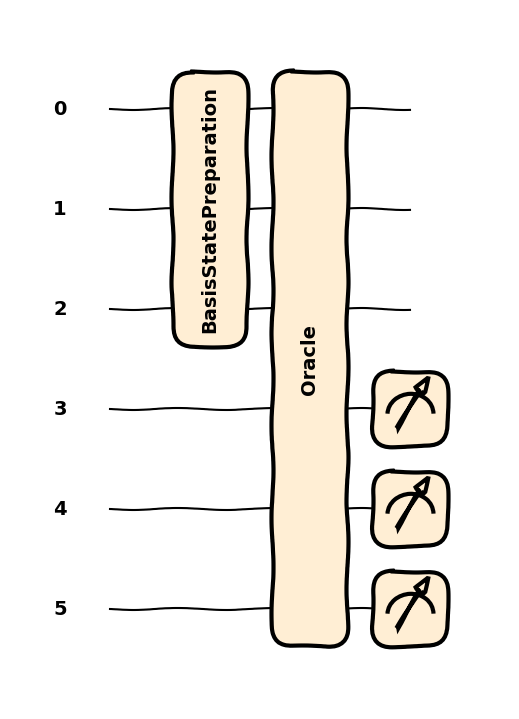

In [5]:
qml.draw_mpl(oracle_test)(np.zeros(N))
plt.show()

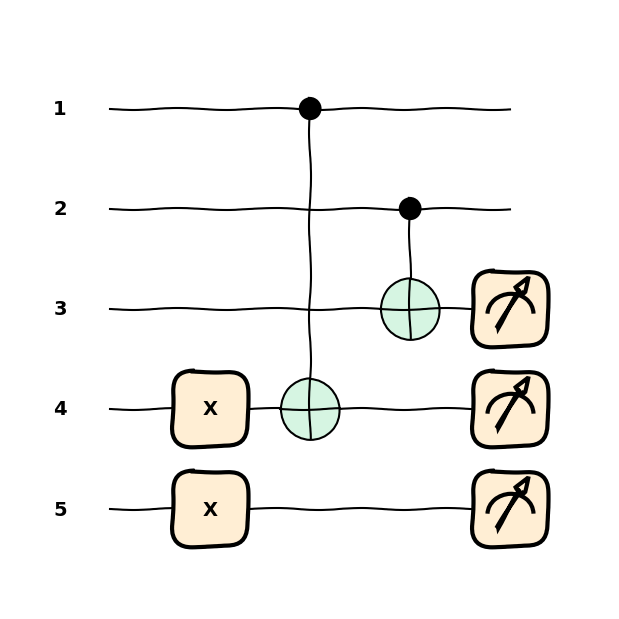

In [6]:
qml.draw_mpl(oracle_test, expansion_strategy='device')(np.zeros(N))
plt.show()

In [7]:
basis_states = [f"{i:0{N}b}" for i in range(2**N)]
basis_states = [list(map(int, list(state))) for state in basis_states]
basis_states

[[0, 0, 0],
 [0, 0, 1],
 [0, 1, 0],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 1],
 [1, 1, 0],
 [1, 1, 1]]

In [8]:
results = []
for state in basis_states:
    # output computational basis to z basis
    result = oracle_test(state)
    result_num = np.argmax(result)
    result_bstr = f"{result_num:0{N}b}"
    result = list(map(int, list(result_bstr)))
    results.append(result)
    print(f"Input: {state} Output: {result}")

Input: [0, 0, 0] Output: [0, 1, 1]
Input: [0, 0, 1] Output: [1, 1, 1]
Input: [0, 1, 0] Output: [0, 0, 1]
Input: [0, 1, 1] Output: [1, 0, 1]
Input: [1, 0, 0] Output: [0, 1, 1]
Input: [1, 0, 1] Output: [1, 1, 1]
Input: [1, 1, 0] Output: [0, 0, 1]
Input: [1, 1, 1] Output: [1, 0, 1]


In [9]:
basis_states = np.array(basis_states)
results = np.array(results)

In [10]:
index = 0
for i in range(1, results.shape[0]):
    if np.array_equal(results[i], results[0]):
        index = i
        break

s = basis_states[index]
s

tensor([1, 0, 0], requires_grad=True)

In [11]:
@qml.qnode(dev)
def oracle_test(state, seed):
    qml.BasisStatePreparation(state, wires=range(N))
    Oracle(N, seed, wires=range(2*N))
    return qml.probs(wires=range(N, 2*N))

In [12]:
def find_s_semi_classical(n):
    s_vec = []
    for seed in range(n):
        results = []
        for state in basis_states:
            # output computational basis to z basis
            result = oracle_test(state, seed)
            result_num = np.argmax(result)
            result_bstr = f"{result_num:0{N}b}"
            result = list(map(int, list(result_bstr)))
            results.append(result)
        results = np.array(results)
        index = 0
        for i in range(1, results.shape[0]):
            if np.array_equal(results[i], results[0]):
                index = i
                break
        s_vec.append(basis_states[index])
    return np.array(s_vec)

In [13]:
s_vec = find_s_semi_classical(100)

In [14]:
s_num_vec = np.sum(s_vec * np.array([4, 2, 1]), axis=1)

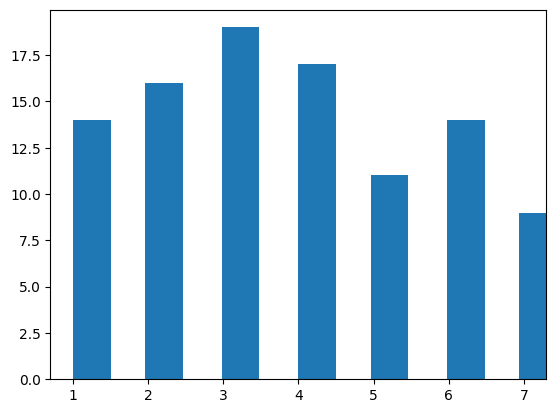

In [15]:
# Plot the histogram
plt.hist(s_num_vec, bins=100, width=0.5)
plt.show()

## Simon's Algorithm